<a href="https://colab.research.google.com/github/Ethan-maaz/plant_village_random_forest_prediction/blob/main/plant_village_random_forest_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip drive/MyDrive/plant-village-dataset/plant_disease.zip


Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [2]:
pip install split-folders[full]

In [3]:
import splitfolders

In [4]:
input_file="plantvillage dataset/color"
output_file="plantvillage dataset splitted"

In [5]:
splitfolders.ratio(input_file, output=output_file, seed=42, ratio=(.7, .2, .1), group_prefix=None)

Copying files: 54305 files [00:40, 1349.08 files/s]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img



In [8]:
len(os.listdir("/content/plantvillage dataset splitted/train"))

38

In [9]:
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [10]:
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3, horizontal_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train=train_datagen.flow_from_directory(directory="/content/plantvillage dataset splitted/train",
                                        target_size=(256,256),
                                        batch_size=32,
                                        class_mode='categorical')
val=val_datagen.flow_from_directory(directory="/content/plantvillage dataset splitted/val",
                                        target_size=(256,256),
                                        batch_size=32,
                                        class_mode='categorical')

Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [12]:
num_classes = len(train.class_indices)
print(f'Number of classes: {num_classes}')

Number of classes: 38


In [13]:
t_img, label=train.next()

In [14]:
t_img.shape

(32, 256, 256, 3)

In [15]:
def plotimage(img_arr, label):
  for im, l in zip(img_arr, label):
    plt.figure(figsize=(5,5))
    img_array = img_to_array(im)
    img_array /= 255.0
    plt.imshow(img_array)
    plt.show()

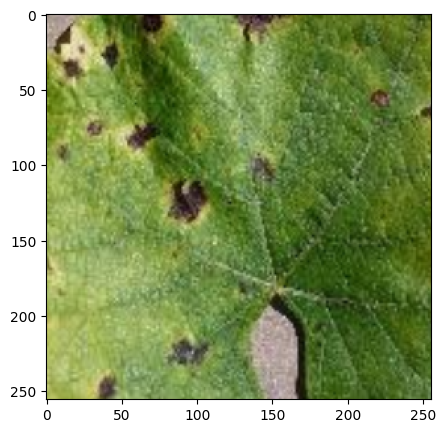

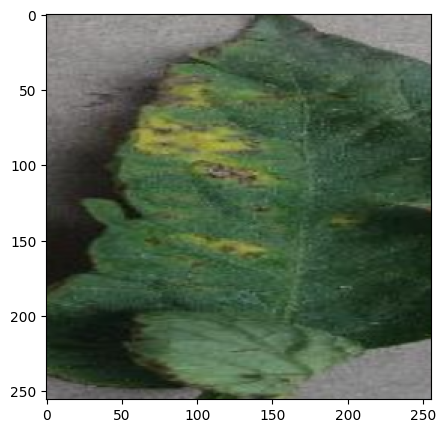

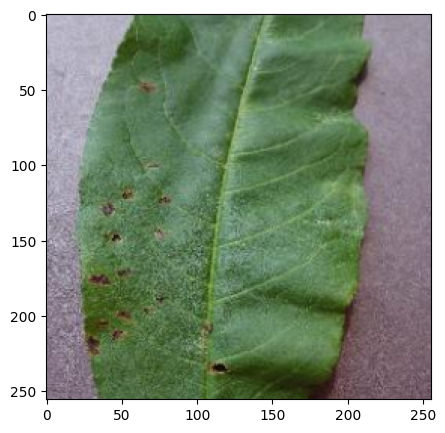

In [16]:
plotimage(t_img[:3],label[:3])

In [17]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [18]:
base_model=VGG19(input_shape=(256,256,3), include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [19]:
for layer in base_model.layers:
  layer.trainable=False

In [20]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [21]:
#compiling the model
x = Flatten()(base_model.output)

x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [23]:
es=EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1)
mc=ModelCheckpoint(filepath="best_model.h5", monitor="val_accuracy",patience=3,min_delta=0.01 , verbose=1, save_best_only=True)

In [24]:
cb=[es,mc]

In [25]:
his = model.fit_generator(train, steps_per_epoch=16,
                          epochs=50,
                          verbose=1,
                          callbacks=cb,
                          validation_data=val,
                          validation_steps=16)

<ipython-input-25-05719c877693>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train, steps_per_epoch=16,


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 35.7491 - accuracy: 0.2305
Epoch 1: val_accuracy improved from -inf to 0.33594, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 23s 849ms/step - loss: 35.7491 - accuracy: 0.2305 - val_loss: 23.8093 - val_accuracy: 0.3359
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 19.7277 - accuracy: 0.4805
Epoch 2: val_accuracy improved from 0.33594 to 0.50391, saving model to best_model.h5
16/16 [==============================] - 13s 832ms/step - loss: 19.7277 - accuracy: 0.4805 - val_loss: 14.0879 - val_accuracy: 0.5039
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 14.0801 - accuracy: 0.5996
Epoch 3: val_accuracy improved from 0.50391 to 0.55664, saving model to best_model.h5
16/16 [==============================] - 12s 756ms/step - loss: 14.0801 - accuracy: 0.5996 - val_loss: 9.4657 - val_accuracy: 0.5566
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 13.5230 - accuracy: 0.5977
Epoch 4: val_accuracy improved from 0.55664 to 0.63477, saving model to best_model.h5
16/16 [==============================] - 13s 835ms/step 

In [27]:
h=his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

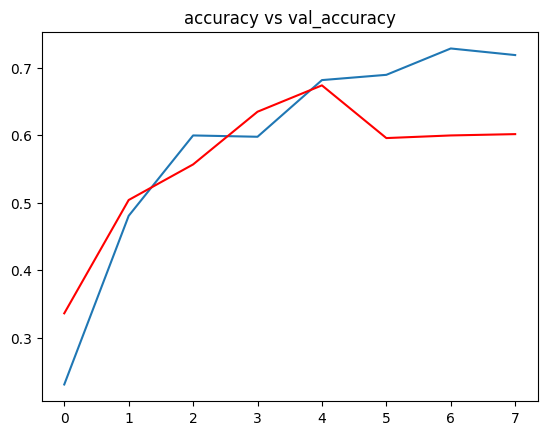

In [28]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c="red")
plt.title("accuracy vs val_accuracy")
plt.show()

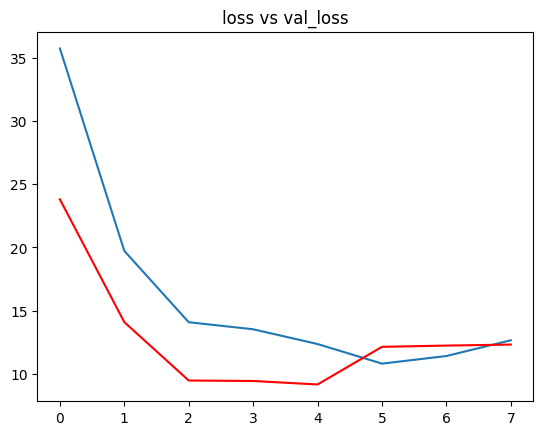

In [29]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c="red")
plt.title("loss vs val_loss")
plt.show()

In [30]:
from keras.models import load_model
model=load_model("best_model.h5")

In [31]:
acc=model.evaluate_generator(val)[1]
print(f"The accuracy of the model is:{acc*100}%")

<ipython-input-31-63a99f309036>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc=model.evaluate_generator(val)[1]


The accuracy of the model is:63.48050236701965%


In [32]:

ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))

In [33]:
def prediction(path):
    img = load_img(path,target_size=(256,256))
    i=img_to_array(img)
    im=preprocess_input(i)
    img=np.expand_dims(im,axis=0)
    pred=np.argmax(model.predict(img))
    print(ref[pred])

In [34]:
path = "/content/plantvillage dataset splitted/test/Corn_(maize)___Common_rust_/RS_Rust 1576.JPG"
prediction(path)

1/1 [==============================] - 0s 295ms/step
Corn_(maize)___Common_rust_


In [35]:
path = "/content/plantvillage dataset splitted/test/Tomato___Bacterial_spot/10f0b483-25a2-4c13-9054-754e9fe08d18___GCREC_Bact.Sp 3812.JPG"
prediction(path)

1/1 [==============================] - 0s 20ms/step
Tomato___Bacterial_spot


In [36]:
train.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma